In [2]:
#2. Database Connection :
import pymysql

# establish a connection to the database
connection = pymysql.connect(host = 'localhost',
                             user = 'root',
                             password = '1234',
                             database = 'crimedata')
connection

OperationalError: (1045, "Access denied for user 'root'@'localhost' (using password: YES)")

# Tried to reinstall the mysql server multiple times due to some technical glitch the connection cannot be established hence the data is read directly from csv file.

# Reading Data

In [ ]:
# Libraries used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy.stats import chi2_contingency

In [22]:
# import pandas lib as pd
 
# read by default 1st sheet of an excel file
cd1 = pd.read_csv('crime_data.csv')
 
print(cd1)

         DR_NO   Date_Rptd    DATE_OCC    AREA_NAME  Crm_Cd  \
0     10304468  01-08-2020  01-08-2020    Southwest     624   
1    190101086  01-02-2020  01-01-2020      Central     624   
2    191501505  01-01-2020  01-01-2020  N Hollywood     745   
3    191921269  01-01-2020  01-01-2020      Mission     740   
4    200100502  01-02-2020  01-02-2020      Central     442   
..         ...         ...         ...          ...     ...   
494  200106614  02-07-2020  02-07-2020      Central     624   
495  200106615  02-07-2020  02-07-2020      Central     624   
496  200106616  02-07-2020  02-07-2020      Central     624   
497  200106617  02-07-2020  01-10-2020      Central     510   
498  200106618  02-07-2020  02-03-2020      Central     745   

                                           Crm_Cd_Desc  Vict_Age Vict_Sex  \
0                             BATTERY - SIMPLE ASSAULT        36        F   
1                             BATTERY - SIMPLE ASSAULT        25        M   
2           

# 3. Data Exploration:
Retrieve basic statistics on the dataset, such as the total number of records and unique values in specific columns.

Identify the distinct crime codes and their descriptions.

In [17]:
def human_readable_size(size, decimal_places=2):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.{decimal_places}f} {unit}"
        size /= 1024.0

def ouno(df):
  """
  Prints information about a DataFrame, including shape, data types, unique values, null values (with descending null value order), 
  and memory usage.

  Args:
      df: Pandas DataFrame.
  """
  print('+'*80)
  print('Shape of the dataframe is: ', df.shape)
  print('+'*80)
  print('{:<20} {:<25} {:<20} {:<25}'.format('Field Name', 'Object Type', 'Unique Label Count', 'Null Values (Percentage)'))
  print('+'*80)

  # Sort by null values in descending order
  df_sorted = df.isnull().sum().sort_values(ascending=False)
  total_rows = len(df)

  for col in df_sorted.index:
    unique_labels_count = len(df[col].unique())
    object_type = str(df[col].dtype)  # Convert dtype to string
    null_values = df[col].isna().sum()
    null_percentage = (null_values / total_rows) * 100
    print('{:<20} {:<25} {:<20} {:<25}'.format(col, object_type, unique_labels_count, f'{null_values} ({null_percentage:.2f}%)'))

  print('+'*80)
  print('Memory usage of the DataFrame:')
  total_memory = df.memory_usage(deep=True).sum()
  print(human_readable_size(total_memory))
  print('+'*80)

In [18]:
ouno(cd1)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shape of the dataframe is:  (499, 13)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Field Name           Object Type               Unique Label Count   Null Values (Percentage) 
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Vict_Sex             object                    4                    27 (5.41%)               
DR_NO                int64                     499                  0 (0.00%)                
Date_Rptd            object                    68                   0 (0.00%)                
DATE_OCC             object                    61                   0 (0.00%)                
AREA_NAME            object                    19                   0 (0.00%)                
Crm_Cd               int64                     42                   0 (0.00%)                
Crm_Cd_Desc          object                    42            

In [31]:
def fetch_label_frequencies(df, field_name):
    """
    Fetches the frequency of each label of a specified field from the DataFrame.

    Args:
        df: Pandas DataFrame.
        field_name: The name of the field (column) for which to fetch label frequencies.

    Returns:
        A pandas Series with label frequencies.
    """
    if field_name in df.columns:
        frequencies = df[field_name].value_counts()
        return frequencies
    else:
        raise ValueError(f"Field name '{field_name}' not found in DataFrame.")

In [32]:
fetch_label_frequencies(cd1,'Vict_Sex')

Vict_Sex
M    278
F    155
X     39
Name: count, dtype: int64

In [14]:
# Extract distinct values of Crm_Cd and corresponding Crm_Cd_Desc
dccd = cd1[['Crm_Cd', 'Crm_Cd_Desc']].drop_duplicates()
print(dccd)

     Crm_Cd                                        Crm_Cd_Desc
0       624                           BATTERY - SIMPLE ASSAULT
2       745           VANDALISM - MISDEAMEANOR ($399 OR UNDER)
3       740  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...
4       442           SHOPLIFTING - PETTY THEFT ($950 & UNDER)
5       946                          OTHER MISCELLANEOUS CRIME
6       341  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...
7       330                              BURGLARY FROM VEHICLE
8       930             CRIMINAL THREATS - NO WEAPON DISPLAYED
10      648                                              ARSON
12      354                                  THEFT OF IDENTITY
14      230     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
17      761                                    BRANDISH WEAPON
19      350                                      THEFT, PERSON
22      310                                           BURGLARY
25      480                                      BIKE -

In [39]:
def temporal_aspects(df):
    """
    Summarizes the temporal aspects of a DataFrame including earliest and latest dates,
    distribution of records over time, and frequency of records by year, month, and day of the week.
    Additionally, plots the frequency distributions with percentages in bar charts and shows values on the bars.

    Args:
        df: Pandas DataFrame.
    """
    # Convert date columns to datetime
    df['Date_Rptd'] = pd.to_datetime(df['Date_Rptd'], errors='coerce')
    df['DATE_OCC'] = pd.to_datetime(df['DATE_OCC'], errors='coerce')
    
    print('+'*80)
    print('Temporal Aspects of the DataFrame')
    print('+'*80)
    
    for date_col in ['Date_Rptd', 'DATE_OCC']:
        print(f'\nColumn: {date_col}')
        earliest_date = df[date_col].min()
        latest_date = df[date_col].max()
        print(f'Earliest Date: {earliest_date}')
        print(f'Latest Date: {latest_date}')
        
        # Distribution of records over time
        print('\nDistribution over time:')
        distribution = df[date_col].dt.to_period('M').value_counts().sort_index()
        print(distribution)
        
        # Frequency of records by year, month, and day of the week
        print('\nFrequency by Year:')
        year_freq = df[date_col].dt.year.value_counts().sort_index()
        print(year_freq)
        
        print('\nFrequency by Month:')
        month_freq = df[date_col].dt.month.value_counts().sort_index()
        print(month_freq)
        
        print('\nFrequency by Day of the Week:')
        day_freq = df[date_col].dt.day_name().value_counts().sort_index()
        print(day_freq)
        
        # Plotting the distributions
        fig, axes = plt.subplots(3, 1, figsize=(12, 18))
        
        # Plot Year Frequency
        sns.barplot(x=year_freq.index, y=year_freq.values, ax=axes[0],palette="viridis")
        axes[0].set_title(f'Frequency by Year for {date_col}')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Frequency')
        for p in axes[0].patches:
            axes[0].annotate(f'{p.get_height()} & ({(p.get_height() / len(df) * 100):.2f}%)', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
        
        # Plot Month Frequency
        sns.barplot(x=month_freq.index, y=month_freq.values, ax=axes[1],palette="viridis")
        axes[1].set_title(f'Frequency by Month for {date_col}')
        axes[1].set_xlabel('Month')
        axes[1].set_ylabel('Frequency')
        for p in axes[1].patches:
            axes[1].annotate(f'{p.get_height()} & ({(p.get_height() / len(df) * 100):.2f}%)', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
        
        # Plot Day of the Week Frequency
        sns.barplot(x=day_freq.index, y=day_freq.values, ax=axes[2],palette="viridis")
        axes[2].set_title(f'Frequency by Day of the Week for {date_col}')
        axes[2].set_xlabel('Day of the Week')
        axes[2].set_ylabel('Frequency')
        for p in axes[2].patches:
            axes[2].annotate(f'{p.get_height()} & ({(p.get_height() / len(df) * 100):.2f}%)', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
        
        plt.tight_layout()
        plt.show()
    
    print('+'*80)

# Example usage
# Assuming you have a dataframe named 'cd1'
# cd1 = pd.read_csv('your_file.csv')
# temporal_aspects(cd1)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Temporal Aspects of the DataFrame
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Column: Date_Rptd
Earliest Date: 2020-01-01 00:00:00
Latest Date: 2022-08-06 00:00:00

Distribution over time:
Date_Rptd
2020-01    309
2020-02    134
2020-03      4
2020-04      5
2020-05      5
2020-06      5
2020-07      3
2020-08      3
2020-09      4
2020-10      4
2020-11      6
2020-12      9
2021-01      1
2021-03      1
2021-04      1
2021-11      1
2021-12      2
2022-02      1
2022-08      1
Freq: M, Name: count, dtype: int64

Frequency by Year:
Date_Rptd
2020    491
2021      6
2022      2
Name: count, dtype: int64

Frequency by Month:
Date_Rptd
1     310
2     135
3       5
4       6
5       5
6       5
7       3
8       4
9       4
10      4
11      7
12     11
Name: count, dtype: int64

Frequency by Day of the Week:
Date_Rptd
Friday       52
Monday       60
Saturday     91
Sund

C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\3230578321.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_freq.index, y=year_freq.values, ax=axes[0],palette="viridis")
C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\3230578321.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_freq.index, y=month_freq.values, ax=axes[1],palette="viridis")
C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\3230578321.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_freq.index, y=day_freq.values, ax=axes[2],palette="viridis")


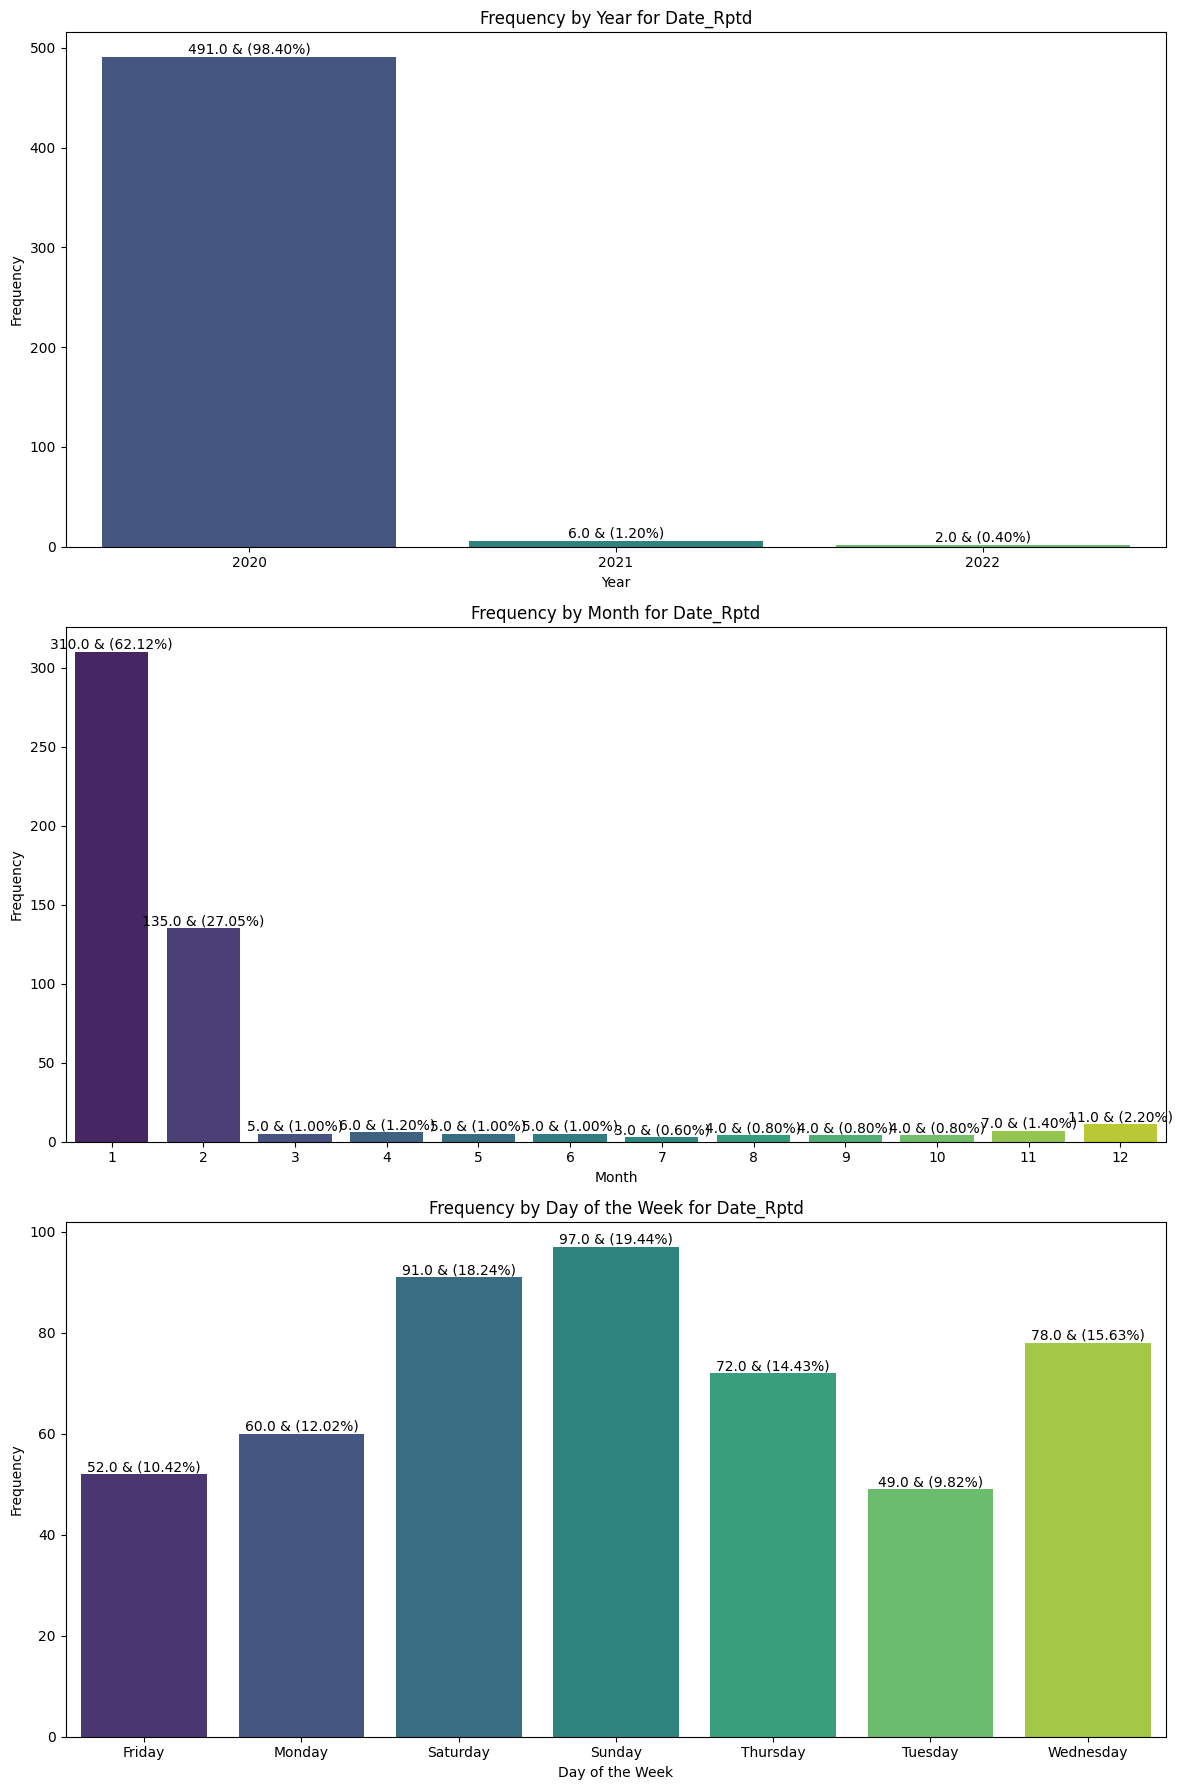


Column: DATE_OCC
Earliest Date: 2020-01-01 00:00:00
Latest Date: 2020-12-12 00:00:00

Distribution over time:
DATE_OCC
2020-01    314
2020-02    130
2020-03      4
2020-04      5
2020-05      5
2020-06      6
2020-07      3
2020-08      3
2020-09      5
2020-10      4
2020-11      8
2020-12     12
Freq: M, Name: count, dtype: int64

Frequency by Year:
DATE_OCC
2020    499
Name: count, dtype: int64

Frequency by Month:
DATE_OCC
1     314
2     130
3       4
4       5
5       5
6       6
7       3
8       3
9       5
10      4
11      8
12     12
Name: count, dtype: int64

Frequency by Day of the Week:
DATE_OCC
Friday        62
Monday        61
Saturday     113
Sunday        69
Thursday      60
Tuesday       48
Wednesday     86
Name: count, dtype: int64


C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\3230578321.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_freq.index, y=year_freq.values, ax=axes[0],palette="viridis")
C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\3230578321.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_freq.index, y=month_freq.values, ax=axes[1],palette="viridis")
C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\3230578321.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_freq.index, y=day_freq.values, ax=axes[2],palette="viridis")


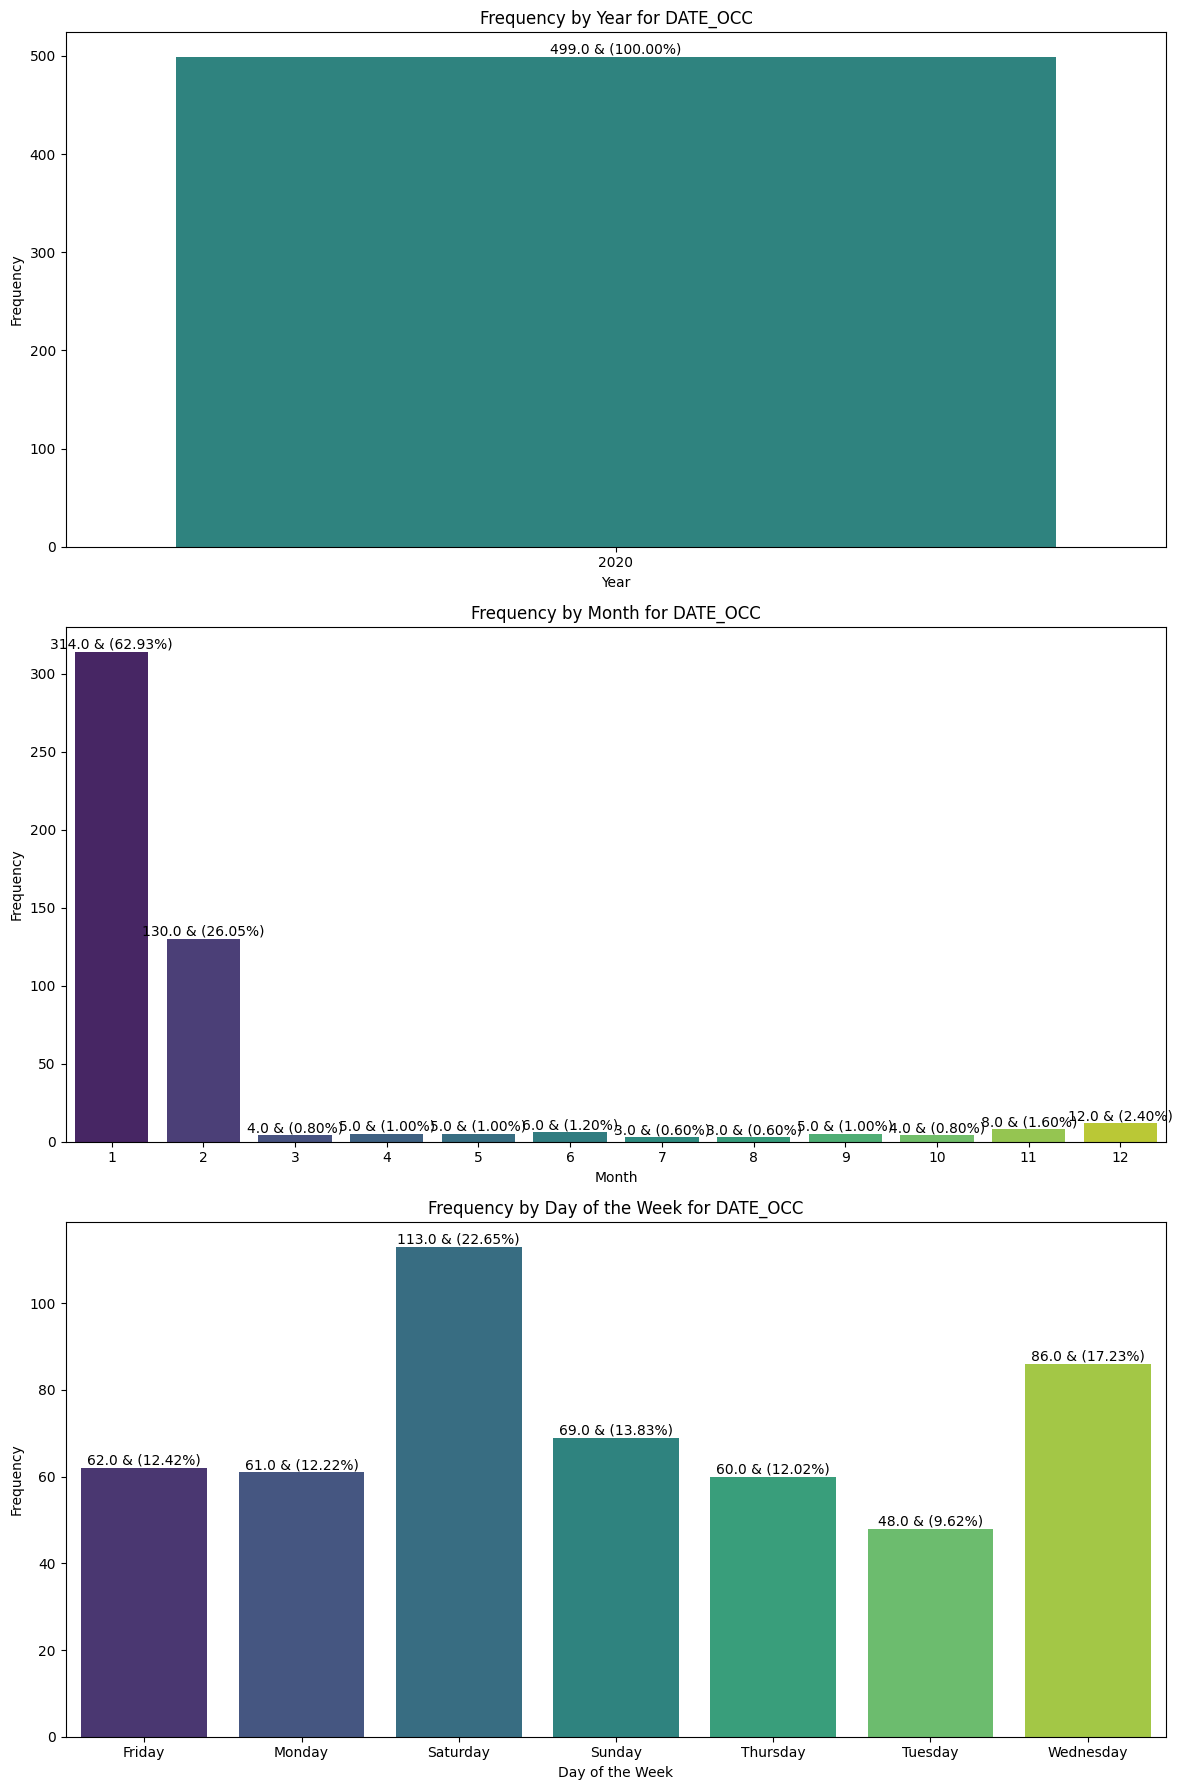

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [40]:
temporal_aspects(cd1)

# 4. Temporal Analysis
   - Analyze the temporal aspects of the data.

   - Determine trends in crime occurrence over time.

In [42]:
# Performing temporal analysis on weekly basis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def wta(df):
    """
    Summarizes the temporal aspects of a DataFrame including earliest and latest dates,
    distribution of records over time on a weekly basis, and frequency of records by week of the year.
    Additionally, plots the frequency distributions with percentages in bar charts and shows values on the bars.

    Args:
        df: Pandas DataFrame.
    """
    # Convert date columns to datetime
    df['Date_Rptd'] = pd.to_datetime(df['Date_Rptd'], errors='coerce')
    df['DATE_OCC'] = pd.to_datetime(df['DATE_OCC'], errors='coerce')
    
    print('+'*80)
    print('Temporal Aspects of the DataFrame')
    print('+'*80)
    
    for date_col in ['Date_Rptd', 'DATE_OCC']:
        print(f'\nColumn: {date_col}')
        earliest_date = df[date_col].min()
        latest_date = df[date_col].max()
        print(f'Earliest Date: {earliest_date}')
        print(f'Latest Date: {latest_date}')
        
        # Distribution of records over time on a weekly basis
        print('\nDistribution over time (Weekly):')
        df['Week'] = df[date_col].dt.to_period('W').dt.start_time
        weekly_distribution = df['Week'].value_counts().sort_index()
        print(weekly_distribution)
        
        # Frequency of records by week of the year
        df['Week_of_Year'] = df[date_col].dt.isocalendar().week
        df['Year'] = df[date_col].dt.year
        
        print('\nFrequency by Week of the Year:')
        week_of_year_freq = df.groupby(['Year', 'Week_of_Year']).size()
        print(week_of_year_freq)
        
        # Plotting the weekly distributions
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot Weekly Frequency
        sns.lineplot(data=weekly_distribution, ax=ax)
        ax.set_title(f'Weekly Distribution for {date_col}')
        ax.set_xlabel('Week')
        ax.set_ylabel('Frequency')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}\n({(p.get_height() / len(df) * 100):.2f}%)', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
        
        plt.tight_layout()
        plt.show()
    
    print('+'*80)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Temporal Aspects of the DataFrame
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Column: Date_Rptd
Earliest Date: 2020-01-01 00:00:00
Latest Date: 2022-08-06 00:00:00

Distribution over time (Weekly):
Week
2019-12-30    120
2020-01-06    189
2020-01-27     44
2020-02-03     88
2020-02-10      2
2020-03-02      1
2020-03-09      3
2020-04-06      5
2020-05-04      3
2020-05-11      2
2020-06-01      1
2020-06-08      4
2020-06-29      1
2020-07-06      2
2020-08-03      1
2020-08-10      2
2020-08-31      1
2020-09-07      3
2020-10-05      4
2020-11-02      5
2020-11-09      1
2020-11-30      4
2020-12-07      5
2021-01-04      1
2021-03-01      1
2021-04-05      1
2021-11-08      1
2021-11-29      2
2022-01-31      1
2022-08-01      1
Name: count, dtype: int64

Frequency by Week of the Year:
Year  Week_of_Year
2020  1               120
      2               189
      5  

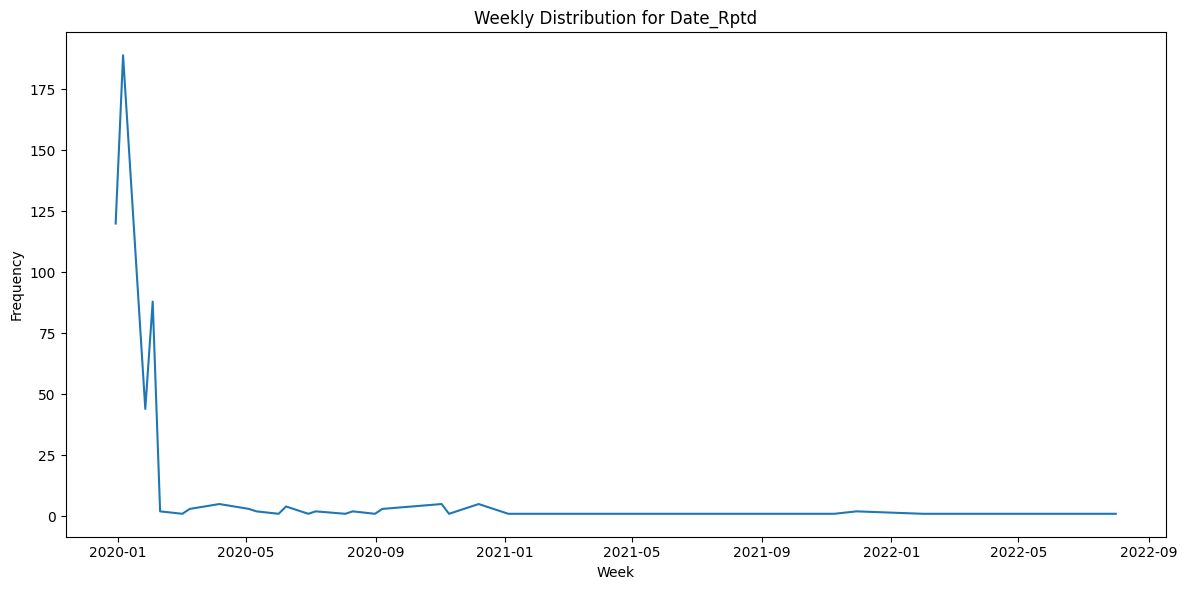


Column: DATE_OCC
Earliest Date: 2020-01-01 00:00:00
Latest Date: 2020-12-12 00:00:00

Distribution over time (Weekly):
Week
2019-12-30    141
2020-01-06    173
2020-01-27     54
2020-02-03     73
2020-02-10      3
2020-03-02      1
2020-03-09      3
2020-04-06      5
2020-05-04      3
2020-05-11      2
2020-06-01      2
2020-06-08      4
2020-06-29      2
2020-07-06      1
2020-07-27      2
2020-08-03      1
2020-08-31      3
2020-09-07      2
2020-10-05      4
2020-10-26      1
2020-11-02      6
2020-11-09      1
2020-11-30      7
2020-12-07      5
Name: count, dtype: int64

Frequency by Week of the Year:
Year  Week_of_Year
2020  1               141
      2               173
      5                54
      6                73
      7                 3
      10                1
      11                3
      15                5
      19                3
      20                2
      23                2
      24                4
      27                2
      28                1
  

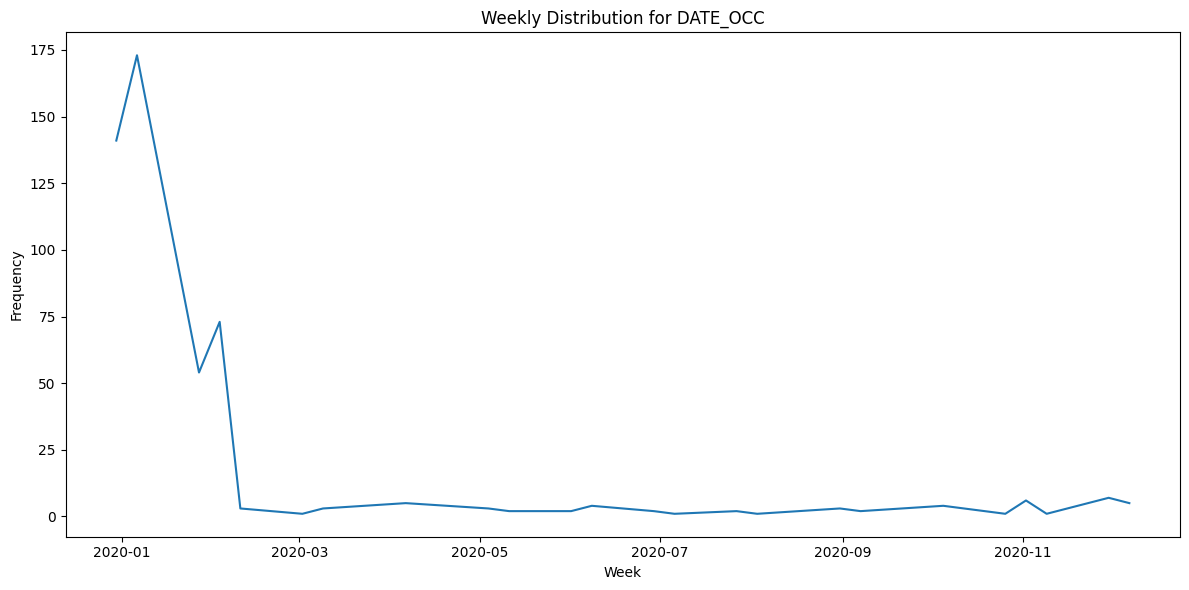

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [43]:
wta(cd1)

# Lets check the difference between the crime occured date and crimes reported date and the TimeGapinDays fares


In [45]:
# Convert date columns to datetime
cd1['Date_Rptd'] = pd.to_datetime(cd1['Date_Rptd'])
cd1['DATE_OCC'] = pd.to_datetime(cd1['DATE_OCC'])

# Calculate the difference in days
cd1['TimeGapDays'] = (cd1['Date_Rptd'] - cd1['DATE_OCC']).dt.days

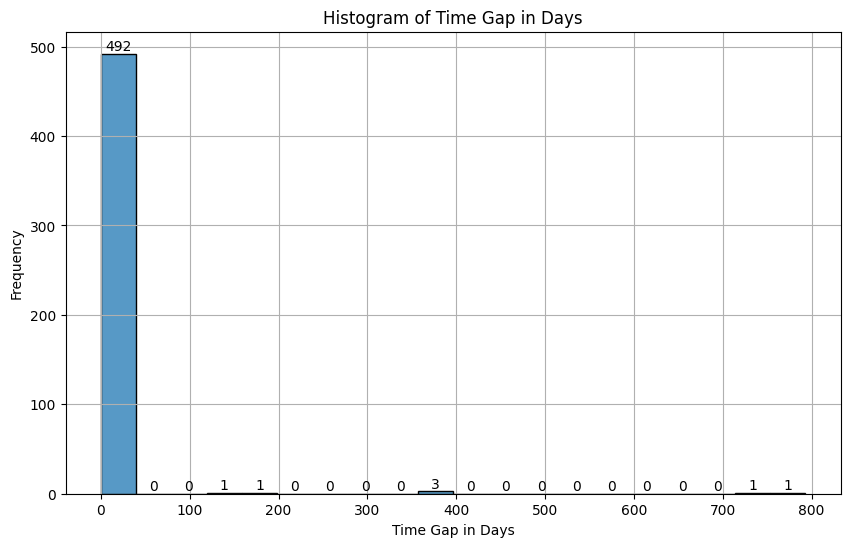

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dataframe named 'cd1' with the 'timegapindays' column

# Example usage
# cd1 = pd.read_csv('your_file.csv')

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(cd1['TimeGapDays'], bins=20, kde=False)

# Add frequency distribution on bars
for rect in plt.gca().patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    plt.text(x, y, f'{int(y)}', ha='center', va='bottom')

plt.title('Histogram of Time Gap in Days')
plt.xlabel('Time Gap in Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Summary 

1. 98% of the crimes have been reported in 2020 and only 1.70% of crimes are reported later.
2. 89.17% of the crimes have occured in the months of Jan and Feb 2020 only.
3. While almost 98% of crimes have been reported immediately within 30-40 days only 7 crimes have been reported after 100 days of crime occurance.
4. 5 of these 7 crimes which are reported very late are Theft of Identity.
5. What does bar plot between the frequency of data and crime code description speak of.

In [58]:
CRD = cd1[cd1['TimeGapDays'] > 100]
print(CRD)

         DR_NO  Date_Rptd   DATE_OCC    AREA_NAME  Crm_Cd  \
62   211422362 2021-12-02 2020-12-02      Pacific     354   
192  211613998 2021-11-08 2020-11-01     Foothill     354   
330  211507896 2021-04-11 2020-11-07  N Hollywood     354   
333  222013040 2022-08-06 2020-06-04      Olympic     354   
334  211715638 2021-12-01 2020-12-09   Devonshire     354   
336  220705246 2022-02-03 2020-02-11     Wilshire     341   
341  210206385 2021-03-01 2020-09-01      Rampart     812   

                                           Crm_Cd_Desc  Vict_Age Vict_Sex  \
62                                   THEFT OF IDENTITY        31        F   
192                                  THEFT OF IDENTITY        64        F   
330                                  THEFT OF IDENTITY        31        M   
333                                  THEFT OF IDENTITY        60        M   
334                                  THEFT OF IDENTITY        56        F   
336  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,

# 5. Spatial Analysis


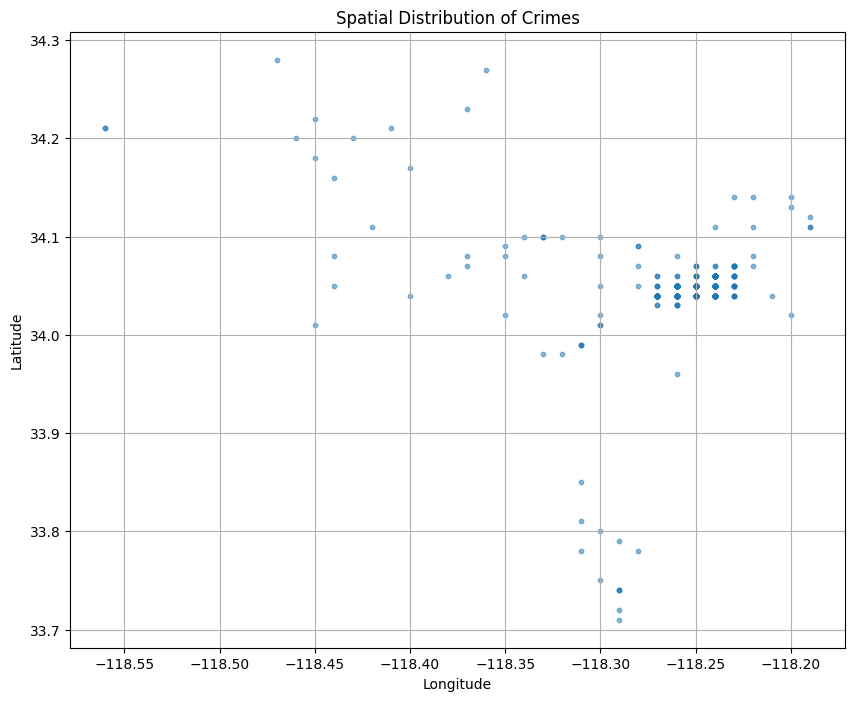

In [59]:
# Assuming you have a dataframe named 'df' with columns 'LAT' and 'LON'

# Example usage
# df = pd.read_csv('your_file.csv')

# Plotting the spatial distribution of crimes
plt.figure(figsize=(10, 8))
plt.scatter(cd1['LON'], cd1['LAT'], s=10, alpha=0.5)
plt.title('Spatial Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [61]:
pip install folium

   ---------------------------------------- 0.0/100.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/100.0 kB ? eta -:--:--
   --------------------------- ----------- 71.7/100.0 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 100.0/100.0 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/82.0 kB ? eta -:--:--
   ---------------------------------------- 82.0/82.0 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
import folium

# Assuming you have a dataframe named 'df' with columns 'LAT' and 'LON'

# Example usage
# df = pd.read_csv('your_file.csv')

# Create a map centered around the mean of latitude and longitude
center_lat = cd1['LAT'].mean()
center_lon = cd1['LON'].mean()
crime_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add markers for each crime location
for index, row in cd1.iterrows():
    folium.Marker([row['LAT'], row['LON']], popup=row['Crm_Cd_Desc']).add_to(crime_map)

# Display the map
crime_map

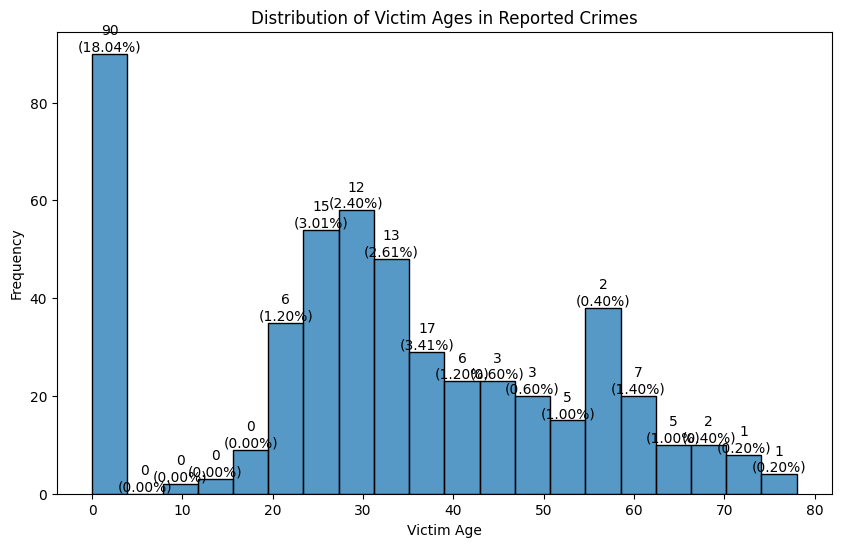

In [66]:
# Assuming you have a dataframe named 'df' with a column 'Vict_Age'

# Example usage
# df = pd.read_csv('your_file.csv')

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(cd1['Vict_Age'], bins=20, kde=False)

# Calculate frequency and percentage
total_victims = len(cd1)
age_counts = cd1['Vict_Age'].value_counts()
for rect in plt.gca().patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    age = int(rect.get_x())  # Get the age from the x-coordinate of the bar
    frequency = age_counts.get(age, 0)
    percentage = (frequency / total_victims) * 100
    plt.text(x, y, f'{frequency}\n({percentage:.2f}%)', ha='center', va='bottom')

# Add titles and labels
plt.title('Distribution of Victim Ages in Reported Crimes')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


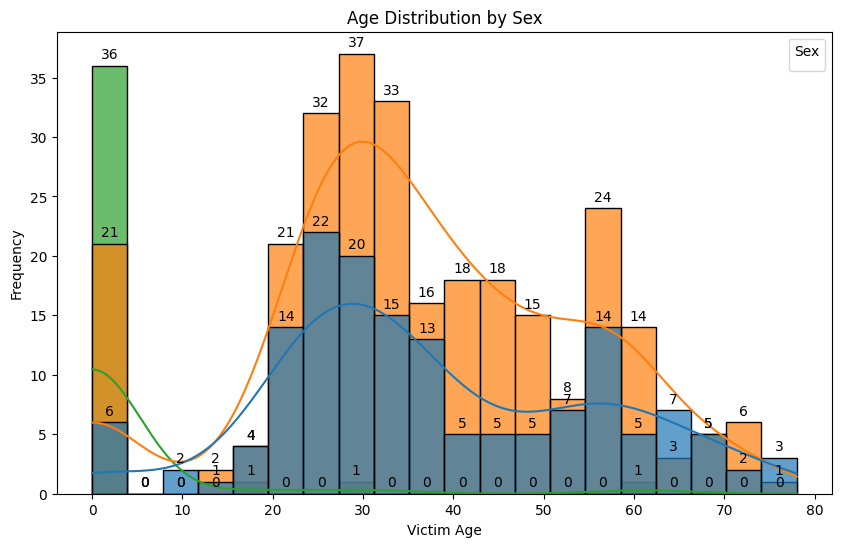

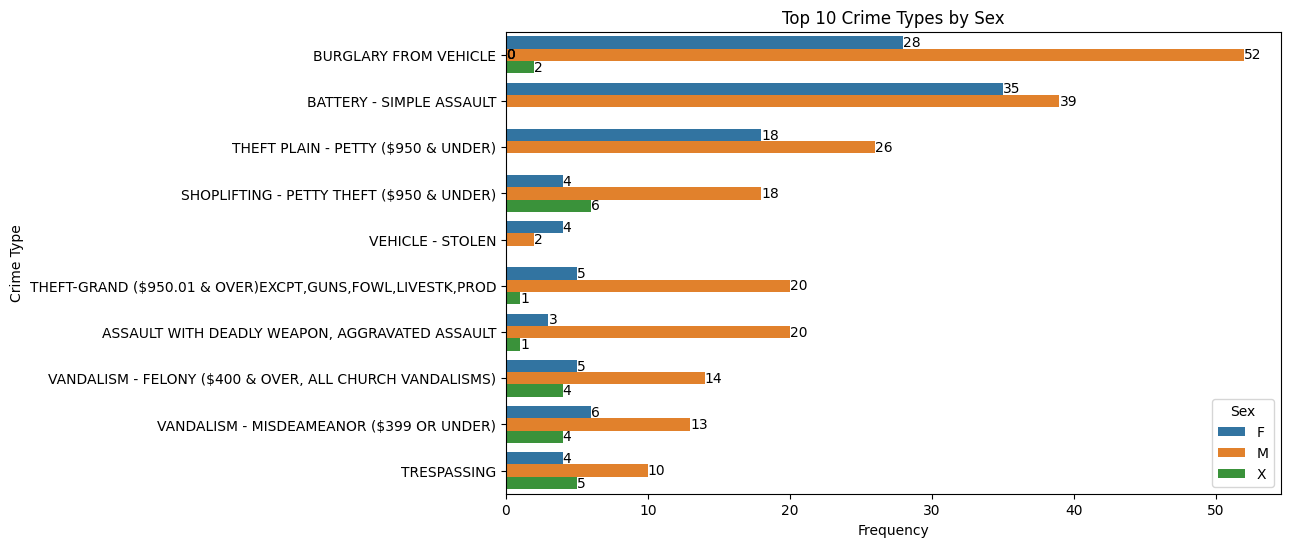

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dataframe named 'df' with columns 'Vict_Sex', 'Vict_Age', and 'Crm_Cd_Desc'

# Example usage
# df = pd.read_csv('your_file.csv')

# 1. Age Distribution by Sex
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=cd1, x='Vict_Age', hue='Vict_Sex', bins=20, kde=True, alpha=0.7)
plt.title('Age Distribution by Sex')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.grid(False)

# Annotate bars with values
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

# Add legend
plt.legend(title='Sex')
plt.show()

# 2. Crime Types by Sex
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=cd1, y='Crm_Cd_Desc', hue='Vict_Sex', order=cd1['Crm_Cd_Desc'].value_counts().index[:10])
plt.title('Top 10 Crime Types by Sex')
plt.xlabel('Frequency')
plt.ylabel('Crime Type')
plt.grid(False)

# Annotate bars with values
for bar in ax.patches:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.0f}', ha='left', va='center')

# Add legend
plt.legend(title='Sex')
plt.show()


In [85]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have a dataframe named 'df' with columns 'Vict_Sex' and 'Crm_Cd'

# Example usage
# df = pd.read_csv('your_file.csv')

# Create a contingency table of victim sex and crime occurrence
contingency_table = pd.crosstab(cd1['Vict_Sex'], cd1['Crm_Cd'])
print(contingency_table)
# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Set significance level
alpha = 0.05

print(f'P-value is {p_value}\nChi Square Value is {round(chi2,2)}')

# Check for significance
if p_value < alpha:
    print("There is a significant difference in crime rates between male and female victims (reject null hypothesis).")
else:
    print("There is no significant difference in crime rates between male and female victims (fail to reject null hypothesis).")

Crm_Cd    210  220  230  310  320  330  341  343  350  351  ...  886  888  \
Vict_Sex                                                    ...             
F           4    1    3    5    1   28    5    0    5    2  ...    0    4   
M           4    3   20    9    1   52   20    1    4    0  ...    2   10   
X           4    0    1    2    0    2    1    0    0    0  ...    0    5   

Crm_Cd    890  900  901  920  930  940  946  956  
Vict_Sex                                          
F           0    1    2    0    4    0    1    1  
M           0    1    1    1    3    1    2    0  
X           1    0    0    0    0    0    1    1  

[3 rows x 42 columns]
P-value is 6.668903482525485e-07
Chi Square Value is 159.42
There is a significant difference in crime rates between male and female victims (reject null hypothesis).


In [86]:
# Count occurrences of each location
location_counts = cd1['Location'].value_counts()

# Get the location with the highest frequency
most_common_location = location_counts.idxmax()
frequency_most_common_location = location_counts.max()

print("Most common location where crimes occur:", most_common_location)
print("Frequency at the most common location:", frequency_most_common_location)

Most common location where crimes occur: 800 N ALAMEDA ST
Frequency at the most common location: 14


C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\2856643775.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_locations.values, y=top_10_locations.index, palette='viridis')


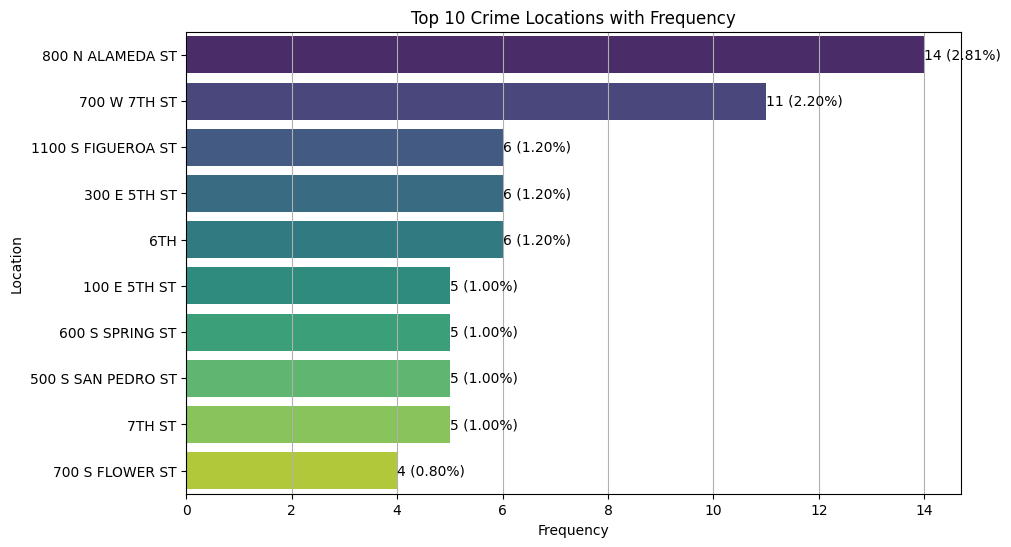

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dataframe named 'df' with a column 'Location'

# Example usage
# df = pd.read_csv('your_file.csv')

# Get top 10 locations with frequency
top_10_locations = cd1['Location'].value_counts().head(10)

# Plot top 10 locations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_locations.values, y=top_10_locations.index, palette='viridis')

# Add values and percentages on bars
for i, (value, location) in enumerate(zip(top_10_locations.values, top_10_locations.index)):
    plt.text(value, i, f'{value} ({value / len(cd1) * 100:.2f}%)', va='center')

# Add labels and title
plt.title('Top 10 Crime Locations with Frequency')
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.grid(axis='x')
plt.show()


C:\Users\ramma\AppData\Local\Temp\ipykernel_4416\2266098836.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_code_distribution.values, y=crime_code_distribution.index, palette='viridis')


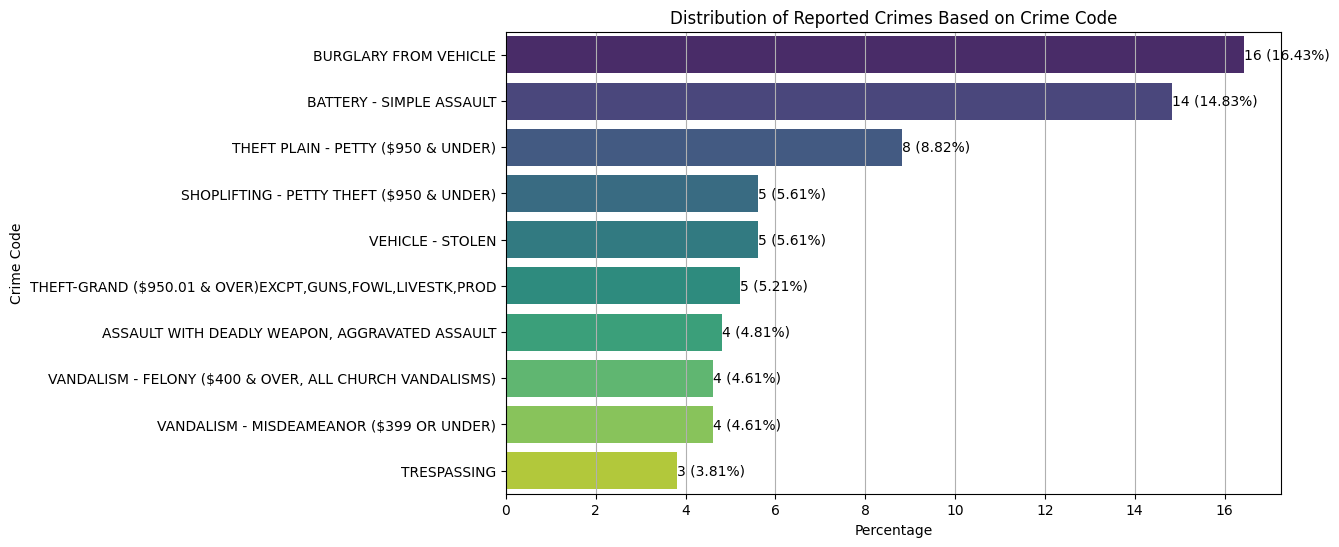

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dataframe named 'df' with a column 'Crm_Cd_Desc'

# Example usage
# df = pd.read_csv('your_file.csv')

# Get the distribution of reported crimes based on Crime Code
crime_code_distribution = cd1['Crm_Cd_Desc'].value_counts(normalize=True).head(10) * 100

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=crime_code_distribution.values, y=crime_code_distribution.index, palette='viridis')

# Add labels with both number and percentage
for i, (value, crime_code) in enumerate(zip(crime_code_distribution.values, crime_code_distribution.index)):
    plt.text(value, i, f'{int(value)} ({value:.2f}%)', va='center')

# Add labels and title
plt.title('Distribution of Reported Crimes Based on Crime Code')
plt.xlabel('Percentage')
plt.ylabel('Crime Code')
plt.grid(axis='x')
plt.show()
